<a href="https://colab.research.google.com/github/mahdiSheykhiGithub/IMDB-Reviews-NLP/blob/main/IMDB_Tfidf_ML_classic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Load data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Reviews/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data.shape

(50000, 2)

In [7]:
data['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

# Preprocessing

In [8]:
soup = BeautifulSoup(data['review'][1])
text = soup.get_text()
text

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

In [9]:
def clean_text(text):
    # html to text format
    soup = BeautifulSoup(text)
    text = soup.get_text()
    # lower case
    text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
    # remove punctuation
    punc = list(string.punctuation)
    # stopword & stemmer
    stop_words = stopwords.words('english')
    stemmer = PorterStemmer()

    filtered = []
    for token in tokens:
        if (token not in stop_words) and (token not in punc):
            word = stemmer.stem(token)
            filtered.append(word)

    text = ' '.join(filtered)
    return text

In [10]:
data['review'] = data['review'].apply(clean_text)

<ipython-input-9-d45883563e29>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)


In [11]:
vectorizer = TfidfVectorizer(min_df = 2)
X = vectorizer.fit_transform(data['review'])

In [12]:
features = vectorizer.get_feature_names_out()

In [13]:
len(features)

44871

In [14]:
data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [15]:
label_enc = LabelEncoder()
y = label_enc.fit_transform(data['sentiment'])

In [30]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling & evaluation

In [18]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = SVC()

In [19]:
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)

SVC()

In [20]:
vc = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2)],
    voting='hard'
)
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1))])

In [21]:
models = {'LogisticRegression' : clf1, 'RandomForest': clf2, 'VotingClassifier' : vc, 'SVC' : clf3}
for name, model in models.items():
  score =  model.score(X_test, y_test)
  print(f'{name} - Accuracy : {score}')

LogisticRegression - Accuracy : 0.8901
RandomForest - Accuracy : 0.8453
VotingClassifier - Accuracy : 0.8634
SVC - Accuracy : 0.8972


In [23]:
y_pred = clf3.predict(X_test)

In [29]:
y_test

array([1, 1, 0, ..., 1, 0, 1])

In [24]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      4961
    positive       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [25]:
print(confusion_matrix(y_test, y_pred))

[[4364  597]
 [ 431 4608]]


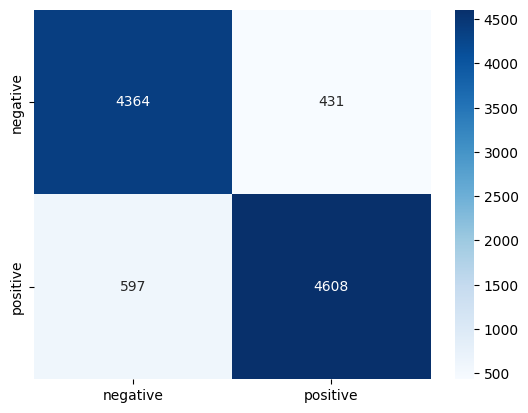

In [26]:
conf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['negative', 'positive'],
    yticklabels=['negative', 'positive']
    )
plt.show()